# HW 5
## Joshua Karten

In [108]:
import numpy as np
import scipy as sci
from numba import jit
import matplotlib.pyplot as plt

In [109]:
def ChargeDensity(Bnd,R,Z):
    rho = np.zeros(len(R))
    N=0.
    for (l,En) in Bnd:
        ur = ComputeSchrod(En, R, l)
        dN = 2*(2*l+1)
        if N+dN <= Z:
            ferm = 1.
        else:
            ferm = (Z-N)/float(dN)
        drho = ur**2 * ferm * dN/(4*np.pi*R**2)
        rho += drho
        N += dN
        print('adding state', (l,En), 'with fermi=', ferm)
        if  N>=Z: 
            break
    return rho

@jit(nopython=True)
def Schroed_deriv(y,r,l,En):
    (u,up) = y
    return np.array([up, (l*(l+1)/r**2-2/r-En)*u])

@jit(nopython=True)
def Numerov(f, x0, dx, dh):

    x = np.zeros(len(f))
    x[0] = x0
    x[1] = x0+dh*dx
    h2 = dh**2
    h12 = h2/12.
    w0=x0*(1-h12*f[0])
    w1=x[1]*(1-h12*f[1])
    xi = x[1]
    fi = f[1]
    for i in range(2,f.size):
        w2 = 2*w1-w0+h2*fi*xi  # here fi,xi=f1,x1 at the first step
        fi = f[i]              # at this point fi=f2 in the first step
        xi = w2/(1-h12*fi)     # xi is not x2 in the first step
        x[i]=xi                # save x2 into x[2]
        w0,w1 = w1,w2
    return x

@jit(nopython=True)
def fShrod(En,l,R):
    return l*(l+1.)/R**2 - 2./R - En

def ComputeSchrod(En, R, l):
    f = fShrod(En,l,R[::-1])
    ur = Numerov(f, 0.0, -1e-7, -R[1]+R[0])[::-1]
    norm = sci.integrate.simpson(ur**2, x=R)
    return ur/np.sqrt(abs(norm))
    
def Shoot(En, R, l):
    ur = ComputeSchrod(En, R, l)
    ur = ur/R**l  
    f0,f1 = ur[0],ur[1]
    f_at_0 = f0 + (f1-f0)*(0-R[0])/(R[1]-R[0]) 
    return f_at_0
def Shoot2(En,R,l):
    ur = ComputeSchrod(En,R,l)
    ur = ur/R**l
    poly = np.polyfit(R[:4], ur[:4], deg=3)
    return np.polyval(poly, 0.0)
def FindBoundStates2(R, l, nmax, Esearch):
    n=0
    Ebnd=[]
    u0 = Shoot2(Esearch[0],R,l)
    for i in range(1,len(Esearch)):
        u1 = Shoot2(Esearch[i],R,l)
        if u0*u1 < 0:
            Ebound = sci.optimize.brentq(Shoot2,Esearch[i-1],Esearch[i],xtol=1e-15,args=(R,l))
            Ebnd.append( (l,Ebound) )
            if len(Ebnd)>nmax: break
            n += 1
            print('Found bound state at E=%14.9f' % Ebound)
        u0 = u1
    return Ebnd 
def FindBoundStates(R, l, nmax, Esearch):
    n=0
    Ebnd=[]
    u0 = Shoot(Esearch[0],R,l)
    for i in range(1,len(Esearch)):
        u1 = Shoot(Esearch[i],R,l)
        if u0*u1 < 0:
            #print 'Sign change at', Esearch[i-1], Esearch[i]
            Ebound = sci.optimize.brentq(Shoot,Esearch[i-1],Esearch[i],xtol=1e-15,args=(R,l))
            Ebnd.append( (l,Ebound) )
            if len(Ebnd)>nmax: break
            n += 1
            print('Found bound state at E=%14.9f' % Ebound)
        u0 = u1
    return Ebnd 

def cmpKey(x):
    return x[1]*1000 + x[0]  # energy has large wait, but degenerate energy states are sorted by l



We will compare the efficacy of shoot and shoot2 where shoot uses a linear fit and shoot2 uses the polyfit numpy function

Found bound state at E=  -0.999999917
Found bound state at E=  -0.249999990
Found bound state at E=  -0.111111108
Found bound state at E=  -0.062499999
Found bound state at E=  -0.039999942
Found bound state at E=  -0.250000000
Found bound state at E=  -0.111111111
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999957
Found bound state at E=  -0.111111111
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999977
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999992
adding state (0, -0.9999999172194989) with fermi= 1.0
adding state (0, -0.2499999896445696) with fermi= 1.0
adding state (1, -0.2500000000016073) with fermi= 1.0
adding state (0, -0.11111110804240991) with fermi= 1.0
adding state (1, -0.11111111111170359) with fermi= 1.0
adding state (2, -0.11111111111111827) with fermi= 1.0
adding state (0, -0.062499998704547956) with fermi= 1.0
adding state (1, -0.06249999999979652) with fermi= 1.0
adding state (2, -0.0624999999

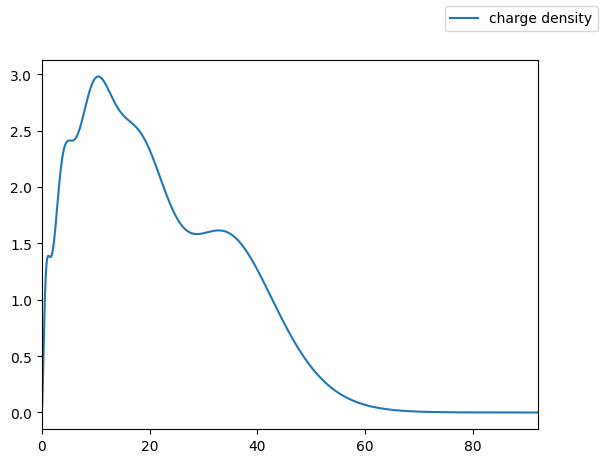

In [110]:

Esearch = -1.2/np.arange(1,20,0.2)**2
R = np.linspace(1e-10,100,20000) #lots of points near zero to create a fine mesh

Z=92

nmax = 5
Bnd=[]
for l in range(nmax-1):
    Bnd += FindBoundStates(R,l,nmax-l,Esearch)
Bnd = sorted(Bnd, key=cmpKey)


rho = ChargeDensity(Bnd,R,Z)
fig,ax = plt.subplots()        
ax.plot(R, rho*(4*np.pi*R**2), label='charge density')
ax.set_xlim([0,Z])
fig.legend()


Found bound state at E=  -1.000000000


Found bound state at E=  -0.250000000
Found bound state at E=  -0.111111111
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999943
Found bound state at E=  -0.250000000
Found bound state at E=  -0.111111111
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999957
Found bound state at E=  -0.111111111
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999977
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999992
adding state (0, -1.0000000000107747) with fermi= 1.0
adding state (0, -0.2500000000000904) with fermi= 1.0
adding state (1, -0.24999999999975447) with fermi= 1.0
adding state (0, -0.11111111111111413) with fermi= 1.0
adding state (1, -0.11111111111103521) with fermi= 1.0
adding state (2, -0.11111111111111827) with fermi= 1.0
adding state (0, -0.06249999999918568) with fermi= 1.0
adding state (1, -0.062499999999503855) with fermi= 1.0
adding state (2, -0.062499999999754696) with fermi= 1.0
adding sta

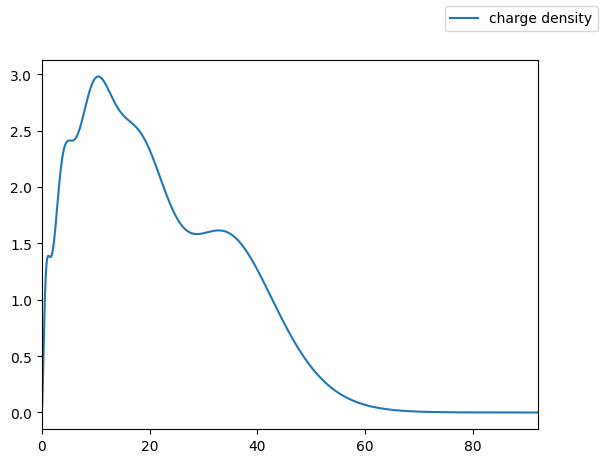

In [111]:

Esearch = -1.2/np.arange(1,20,0.2)**2
R = np.linspace(1e-10,100,20000) #lots of points near zero to create a fine mesh


nmax = 5
Bnd=[]
for l in range(nmax-1):
    Bnd += FindBoundStates2(R,l,nmax-l,Esearch)
Bnd = sorted(Bnd, key=cmpKey)


rho = ChargeDensity(Bnd,R,Z)
fig,ax = plt.subplots()        
ax.plot(R, rho*(4*np.pi*R**2), label='charge density')
ax.set_xlim([0,Z])
fig.legend()


By comparing the numerical energy of the bound states to the found energy, we see that shoot2 has orders of magnitude less error than shoot.

## Z=28

Found bound state at E=  -1.000000000
Found bound state at E=  -0.250000000
Found bound state at E=  -0.111111111
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999943
Found bound state at E=  -0.250000000
Found bound state at E=  -0.111111111
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999957
Found bound state at E=  -0.111111111
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999977
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999992
adding state (0, -1.0000000000107747) with fermi= 1.0
adding state (0, -0.2500000000000904) with fermi= 1.0
adding state (1, -0.24999999999975447) with fermi= 1.0
adding state (0, -0.11111111111111413) with fermi= 1.0
adding state (1, -0.11111111111103521) with fermi= 1.0
adding state (2, -0.11111111111111827) with fermi= 1.0


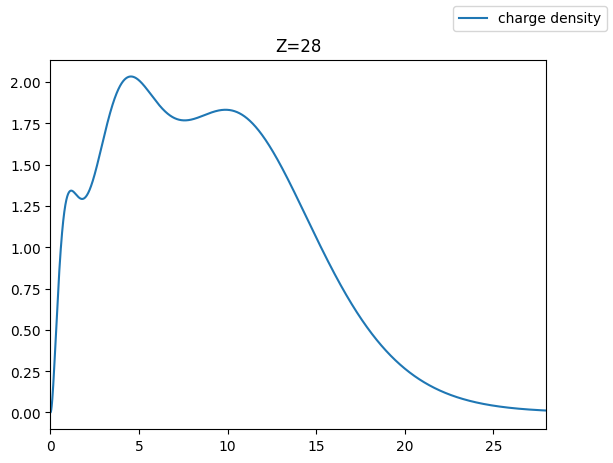

In [112]:

Esearch = -1.2/np.arange(1,20,0.2)**2
R = np.linspace(1e-10,100,20000) #lots of points near zero to create a fine mesh

Z=28
nmax = 5
Bnd=[]
for l in range(nmax-1):
    Bnd += FindBoundStates2(R,l,nmax-l,Esearch)
Bnd = sorted(Bnd, key=cmpKey)


rho = ChargeDensity(Bnd,R,Z)
fig,ax = plt.subplots()        
ax.plot(R, rho*(4*np.pi*R**2), label='charge density')
ax.set_title('Z='+str(Z))

ax.set_xlim([0,Z])
fig.legend()


## Z=92

Found bound state at E=  -1.000000000
Found bound state at E=  -0.250000000
Found bound state at E=  -0.111111111
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999943
Found bound state at E=  -0.250000000
Found bound state at E=  -0.111111111
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999957
Found bound state at E=  -0.111111111
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999977
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999992
adding state (0, -1.0000000000107747) with fermi= 1.0
adding state (0, -0.2500000000000904) with fermi= 1.0
adding state (1, -0.24999999999975447) with fermi= 1.0
adding state (0, -0.11111111111111413) with fermi= 1.0
adding state (1, -0.11111111111103521) with fermi= 1.0
adding state (2, -0.11111111111111827) with fermi= 1.0
adding state (0, -0.06249999999918568) with fermi= 1.0
adding state (1, -0.062499999999503855) with fermi= 1.0
adding state (2, -0.062499999

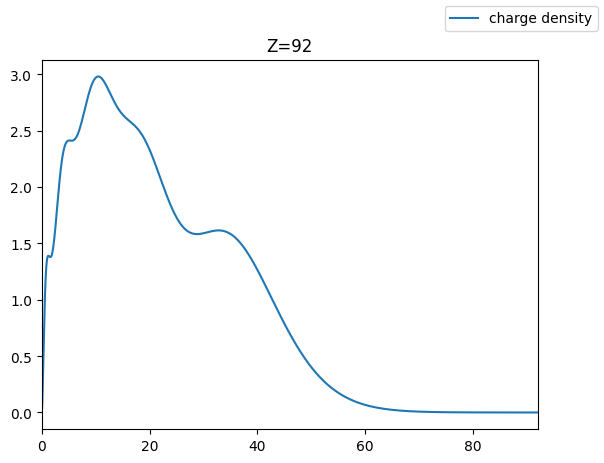

In [113]:

Esearch = -1.2/np.arange(1,20,0.2)**2
R = np.linspace(1e-10,100,20000) #lots of points near zero to create a fine mesh

Z=92
nmax = 5
Bnd=[]
for l in range(nmax-1):
    Bnd += FindBoundStates2(R,l,nmax-l,Esearch)
Bnd = sorted(Bnd, key=cmpKey)


rho = ChargeDensity(Bnd,R,Z)
fig,ax = plt.subplots()        
ax.plot(R, rho*(4*np.pi*R**2), label='charge density')
ax.set_title('Z='+str(Z))

ax.set_xlim([0,Z])
fig.legend()


## Z=94

Found bound state at E=  -1.000000000
Found bound state at E=  -0.250000000
Found bound state at E=  -0.111111111
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999943
Found bound state at E=  -0.250000000
Found bound state at E=  -0.111111111
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999957
Found bound state at E=  -0.111111111
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999977
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999992
adding state (0, -1.0000000000107747) with fermi= 1.0
adding state (0, -0.2500000000000904) with fermi= 1.0
adding state (1, -0.24999999999975447) with fermi= 1.0
adding state (0, -0.11111111111111413) with fermi= 1.0
adding state (1, -0.11111111111103521) with fermi= 1.0
adding state (2, -0.11111111111111827) with fermi= 1.0
adding state (0, -0.06249999999918568) with fermi= 1.0
adding state (1, -0.062499999999503855) with fermi= 1.0
adding state (2, -0.062499999

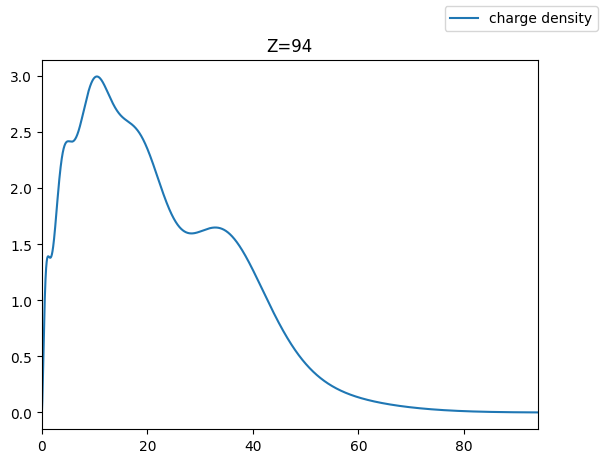

In [114]:

Esearch = -1.2/np.arange(1,20,0.2)**2
R = np.linspace(1e-10,100,20000) #lots of points near zero to create a fine mesh

Z=94
nmax = 5
Bnd=[]
for l in range(nmax-1):
    Bnd += FindBoundStates2(R,l,nmax-l,Esearch)
Bnd = sorted(Bnd, key=cmpKey)


rho = ChargeDensity(Bnd,R,Z)
fig,ax = plt.subplots()        
ax.plot(R, rho*(4*np.pi*R**2), label='charge density')
ax.set_title('Z='+str(Z))
ax.set_xlim([0,Z])
fig.legend()


Things work alright but don't quite fill in the correct order